# Basic stats of AU data comparing T and B

In [1]:
#datafile = 'all_frames.pkl.xz' # FG/UBICOMP data N=151
datafile_km = '../data/all_frames_wclust.pkl.xz' # with AU6_AU12 clusters
datafile_bmm = '../data/all_frames_clust.bmm.pkl.xz' # bmm clusters

CONFIDENCE_TOL = 0.90 # only use data with conf > this

#-----------------

import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:,.3f}'.format
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
# import in scripts dir
import sys
sys.path.append('../scripts')
import compare 

cluster_name2i = {'duchenne':0,'neutral':1,'strong duchenne':2,'6 only':3,'polite':4}

def load_cluster_data(datafile):
    print('\n...loading cluster data')
    if 'pkl' in datafile:
        df = pd.read_pickle(datafile)
    else:
        df = pd.read_csv(datafile, skipinitialspace=True) 
    df = df[df['confidence'] >= CONFIDENCE_TOL]
    # confidence of .90 causes nfiles 302-->298

    for cluster_name in cluster_name2i.keys():
        df[cluster_name] = (df['AU06_AU12_cluster'] == cluster_name2i[cluster_name]).astype(int)

    print('n:',df.shape[0])
    print('# files = ', df['Filename'].nunique())

    print('\ncolumns: ')
    for c in df.columns:
        print(c,end=',')
    print('-------')
    return df
        
df_km = load_cluster_data(datafile_km)
df_bmm = load_cluster_data(datafile_bmm)



...loading cluster data


KeyError: 253

In [7]:
df_clusts = pd.concat([df_km['AU06_AU12_cluster'], 
                       df_bmm['AU06_AU12_cluster']], axis=1)
df_clusts.columns=['km','bmm']
#print(df_clusts)
df_clusts[df_clusts['km'] != df_clusts['bmm']].shape

(851070, 2)

In [9]:
# cluster statistics
print('Average cluster dist over all frames')
print('K-MEANS')
g = df_km.groupby('filetype')
cluster_dist = g[list(cluster_name2i.keys())].mean()
display(cluster_dist)

print('\n\nBETA MIXTURE')
g = df_bmm.groupby('filetype')
cluster_dist = g[list(cluster_name2i.keys())].mean()
display(cluster_dist)

Average cluster dist over all frames
K-MEANS


,duchenne,neutral,strong duchenne,6 only,polite
filetype,,,,,
I-B,0.171,0.370,0.058,0.163,0.237
I-T,0.157,0.440,0.059,0.184,0.160
W-B,0.134,0.439,0.073,0.127,0.228
W-T,0.130,0.417,0.044,0.179,0.231




BETA MIXTURE


,duchenne,neutral,strong duchenne,6 only,polite
filetype,,,,,
I-B,0.440,0.143,0.199,0.056,0.162
I-T,0.418,0.191,0.196,0.089,0.106
W-B,0.403,0.169,0.177,0.073,0.178
W-T,0.478,0.137,0.147,0.080,0.158


### statistical comparisons (Mann Whitney  Utest & Cohen's d)

In [ ]:
def compare_t_b(df_seg,filetype_t,filetype_b):
    """ averages two groups over filename, then compares 
    : df_seg: the subset of df for a given segment, e.g. S2
    : filetype_t: the filetype which forms the t group, e.g. I-T or W-T
    : filetype_b: the filetype which forms the b group, e.g. I-B or W-B
    """
    gt = df_seg[(df_seg['filetype'] == filetype_t)].groupby('Filename')
    gb = df_seg[(df_seg['filetype'] == filetype_b)].groupby('Filename')
    gt_dist = gt[list(cluster_name2i.keys())].mean()
    gb_dist = gb[list(cluster_name2i.keys())].mean()

    cluster_names = list(cluster_name2i.keys())
    statss = []
    for c in cluster_names:
        #mw_stat, mw_p = mannwhitneyu(gwt_dist[c],gwb_dist[c],alternative='two-sided')
        #mw_stat, mw_p = mannwhitneyu(gwb_dist[c],gwt_dist[c],use_continuity=False)
        comp = compare.Compare(gt_dist[c],gb_dist[c])
        statss.append(np.array(comp.calc_stats()))
        #a_mean,b_mean,tt_p,mw_p2,coh_d = stats
    #df_cluster_dist_w = pd.DataFrame(np.vstack((cluster_names,statss[0],statss[1],statss[2],statss[3],statss[4])).T)
    df_cluster_dist = pd.DataFrame(np.array(statss))
    df_cluster_dist.columns=['T mean','B mean','tt p-val','MW p-val','d']
    df_cluster_dist.index = cluster_names
    print(filetype_t,' vs ', filetype_b)
    display(df_cluster_dist)
    print()
    
def do_compare(df_seg):
    compare_t_b(df_seg,'W-T','W-B')
    compare_t_b(df_seg,'I-T','I-B')

#---------------------------------------------
# comparison of T and B for different segments
print('SEGMENT = S2 ONLY - KMEANS')
df_seg = df_km[(df_km['segment'] == 'S2')]
do_compare(df_seg)

print('SEGMENT = S2 ONLY - BMM')
df_seg = df_bmm[(df_bmm['segment'] == 'S2')]
do_compare(df_seg)

In [12]:
print('\nSEGMENT = S2 & S3 - KMEANS')
df_seg = df_km[((df_km['segment'] == 'S2') | (df_km['segment'] == 'S3'))]
do_compare(df_seg)

print('\nSEGMENT = S2 & S3 - BMM')
df_seg = df_bmm[((df_bmm['segment'] == 'S2') | (df_bmm['segment'] == 'S3'))]
do_compare(df_seg)


SEGMENT = S2 & S3 - KMEANS
W-T  vs  W-B


,T mean,B mean,tt p-val,MW p-val,d
duchenne,0.126,0.136,0.675,0.422,0.069
neutral,0.400,0.406,0.910,0.425,0.019
strong duchenne,0.031,0.057,0.039,0.063,0.345
6 only,0.212,0.161,0.216,0.009,-0.206
polite,0.232,0.240,0.833,0.363,0.035



I-T  vs  I-B


,T mean,B mean,tt p-val,MW p-val,d
duchenne,0.157,0.155,0.945,0.296,-0.011
neutral,0.424,0.348,0.172,0.138,-0.226
strong duchenne,0.045,0.049,0.741,0.127,0.055
6 only,0.201,0.196,0.910,0.177,-0.019
polite,0.174,0.252,0.032,0.026,0.356




SEGMENT = S2 & S3 - BMM
W-T  vs  W-B


,T mean,B mean,tt p-val,MW p-val,d
duchenne,0.508,0.447,0.151,0.081,-0.239
neutral,0.118,0.139,0.567,0.425,0.095
strong duchenne,0.133,0.166,0.248,0.241,0.192
6 only,0.089,0.065,0.321,0.011,-0.165
polite,0.152,0.184,0.355,0.166,0.153



I-T  vs  I-B


,T mean,B mean,tt p-val,MW p-val,d
duchenne,0.456,0.460,0.925,0.480,0.016
neutral,0.171,0.122,0.241,0.178,-0.194
strong duchenne,0.174,0.181,0.809,0.203,0.040
6 only,0.087,0.069,0.508,0.041,-0.109
polite,0.112,0.168,0.066,0.033,0.305


### the following is a comparison of frequency of exact zero values in AU6 & AU12

In [15]:
# first load AU data
datafile = '../data/all_frames.pkl.xz' # FG/UBICOMP data N=151
print('\n...loading AU data')
if 'pkl' in datafile:
    df = pd.read_pickle(datafile)
else:
    df = pd.read_csv(datafile, skipinitialspace=True) 
df = df[df['confidence'] >= CONFIDENCE_TOL]
# confidence of .90 causes nfiles 302-->298

print('n:',df.shape[0])
print('# files = ', df['Filename'].nunique())

print('\ncolumns: ')
for c in df.columns:
    print(c,end=',')



...loading AU data
n: 1246319
# files =  298

columns: 
Filename,filetype,segment,timestamp,confidence,success,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,pose_Rz,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,

In [16]:
df['au6_zero'] = (df['AU06_r'] == 0).astype(int)
df['au12_zero'] = (df['AU12_r'] == 0).astype(int)
df['au6_12_zero'] = ((df['AU06_r'] == 0) & (df['AU12_r'] == 0)).astype(int)
df_seg = df[((df['segment'] == 'S2') | (df['segment'] == 'S3'))]
g = df_seg.groupby(['filetype'])
display(g['au6_zero','au12_zero','au6_12_zero'].mean())

,au6_zero,au12_zero,au6_12_zero
filetype,,,
I-B,0.273,0.183,0.128
I-T,0.276,0.269,0.175
W-B,0.324,0.214,0.150
W-T,0.268,0.193,0.121


AU06_r histograms by filetype


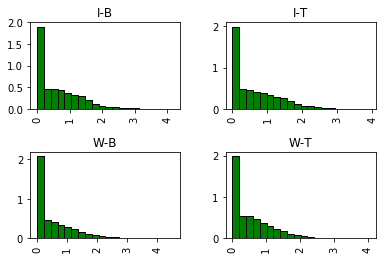


AU12_r histograms by filetype


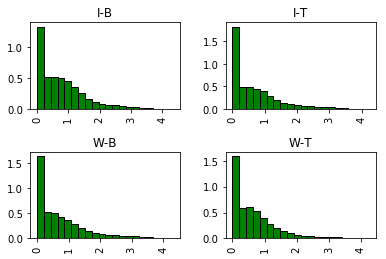

In [17]:
g = df.groupby(['filetype', 'Filename'])
#g['AU06_r','AU06_c'].mean()
#display(g['au6_zero','au12_zero','au6_12_zero'].mean())
print('AU06_r histograms by filetype')
df['AU06_r'].hist(by=df['filetype'],color='green', histtype='bar', 
                  ec='black', normed=1, bins=20, grid=True)
plt.show()

print('\nAU12_r histograms by filetype')
df['AU12_r'].hist(by=df['filetype'],color='green', histtype='bar', 
                  ec='black', normed=1, bins=20, grid=True)
plt.show()

## Correlations

In [39]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).reset_index()
    au_corr.columns = ['0','1','r']
    au_corr['abs(r)'] = au_corr['r'].abs()
    au_corr.sort_values(by='abs(r)',ascending=False, inplace=True)
    return au_corr[0:n]
#============================================================
print("Top AU_r Correlations")

df_seg = df[(df['segment'] == 'S2')]
df_t = df_seg[df_seg['filetype']=='W-T']
df_b = df_seg[df_seg['filetype']=='W-B']
df_rt = df_t[df_t.columns[df_t.columns.str.contains('_r')]]
df_rb = df_b[df_b.columns[df_b.columns.str.contains('_r')]]
t_corr = get_top_abs_correlations(df_rt, 15)
b_corr = get_top_abs_correlations(df_rb, 15)

print('W-T correlations')
display(t_corr)

print('\nW-B correlations')
display(b_corr)

Top AU_r Correlations
W-T correlations


,0,1,r,abs(r)
0,AU01_r,AU02_r,0.684,0.684
58,AU06_r,AU07_r,0.563,0.563
61,AU06_r,AU12_r,0.558,0.558
91,AU10_r,AU12_r,0.537,0.537
60,AU06_r,AU10_r,0.534,0.534
133,AU25_r,AU26_r,0.504,0.504
100,AU12_r,AU14_r,0.423,0.423
92,AU10_r,AU14_r,0.371,0.371
130,AU23_r,AU25_r,-0.328,0.328
122,AU17_r,AU23_r,0.325,0.325



W-B correlations


,0,1,r,abs(r)
61,AU06_r,AU12_r,0.725,0.725
0,AU01_r,AU02_r,0.713,0.713
91,AU10_r,AU12_r,0.570,0.570
60,AU06_r,AU10_r,0.526,0.526
58,AU06_r,AU07_r,0.526,0.526
100,AU12_r,AU14_r,0.443,0.443
133,AU25_r,AU26_r,0.413,0.413
122,AU17_r,AU23_r,0.410,0.410
92,AU10_r,AU14_r,0.405,0.405
67,AU06_r,AU25_r,0.357,0.357
